In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numba as nb
import pandas_ta as ta
import os
import datetime
import json
from tabulate import tabulate
import sys
sys.path.append('../..')
import vectorbtpro as vbt
from vectorbtpro.portfolio.enums import SizeType
from src.utils import fu
from src.utils import plot_return_mdd
from src.strategy.BackTester import BackTester
from src.strategy.Analyzer import Analyzer
from src.strategy.MultiTester import MultiTester
from src.utils import plot_return_mdd,twinx_plot # as utils
from bband import get_data,Strategy

### 樣本內全參數 (多、空)

In [2]:
import ast
import pandas as pd
import hiplot as hip

def insample_params_highland(coin:str, freq: str, direction: str):
    params_df = pd.read_csv(f'opt/{freq}/{coin}/{direction}_record_df.csv').drop(columns=['Unnamed: 0'])
    params_df['params'] = params_df['params'].apply(ast.literal_eval)
    temp_df = params_df['params'].apply(pd.Series)
    df = pd.concat([params_df.drop(columns='params'), temp_df], axis=1)
    target = df[['window_l_k','window_l_d','window_s_k','window_s_d','Sharpe Ratio','Calmar Ratio','Win Rate [%]']]
    data_for_hiplot = target.to_dict(orient='records')
    exp = hip.Experiment.from_iterable(data_for_hiplot)
    exp.display(force_full_width=False, width=400, height=100)


In [6]:
symbol_list = ['ETH','BTC','BNB','SOL','MATIC',
               'XRP','DYDX','AVAX','LINK','GAS',
               'DOGE','ORDI','TRB','WLD','ADA',
               'OP','FIL','ZRX','LTC','RUNE','ATOM',
               'ARB','GMT','ETC','ARK','BCH','DOT',
               '1000PEPE','LDO','SUI','GALA','CAKE',
               'APE','INJ','FTM','APT','YFI','OMG',
               'SEI','EOS','1000SHIB','NEAR','STORJ',
               '1000FLOKI','MKR','CYBER','UNI','STRAX',
               'BLUR','SUSHI','WAVES','MASK','MANA',
               'EGLD','AAVE','NEO','FET','TRX','GRT','ALGO','STX','XLM']

insample_long_dict = {}
insample_short_dict = {}
for freq in ['5T','15T','1h','4h']:
    insample_long_dict[freq] = []
    insample_short_dict[freq] = []
    for coin in symbol_list:
        for direction in ['long','short']:
            try:
                params_df = pd.read_csv(f'opt/{freq}/{coin}/{direction}_record_df.csv').drop(columns=['Unnamed: 0'])
                if params_df['Sharpe Ratio'].iloc[0] > 2:
                    if direction == 'long':
                        insample_long_dict[freq].append(coin)
                    else:
                        insample_short_dict[freq].append(coin)
            except:
                pass


### 樣本外
取樣本內前一半參數來看樣本外表現


In [4]:
df_dict = {}
candidate = ['ETH','BTC','BNB','SOL','MATIC',
               'XRP','DYDX','AVAX','LINK','GAS',
               'DOGE','ORDI','TRB','WLD','ADA',
               'OP','FIL','ZRX','LTC','RUNE','ATOM',
               'ARB','GMT','ETC','ARK','BCH','DOT',
               'LDO','SUI','GALA','CAKE',
               'APE','INJ','FTM','APT','YFI','OMG',
               'SEI','EOS','1000SHIB','NEAR',
               'MKR','CYBER','UNI',
               'BLUR','SUSHI','WAVES','MASK','MANA',
               'EGLD','AAVE','NEO','FET','TRX','GRT','ALGO','STX','XLM']
for coin in candidate:
    df_dict[coin] = pd.read_hdf(f'/Users/johnsonhsiao/Desktop/data/{coin}USDT_PERPETUAL.h5')

In [5]:
from tqdm.auto import tqdm
start = '2022-01-01'
sep = ''
end = ''

def outample_params_highland(freq, side, coin):
    outsample_record = []
    params_df = pd.read_csv(f'/Users/johnsonhsiao/DC_capital_intern/strategy_research/CTA_TEST/Crypto/bband/opt/{freq}/{coin}/{direction}_record_df.csv')
    for idx , row in tqdm(params_df[:int(len(params_df)/2)].iterrows(), total=int(len(params_df)/2), desc="Processing"):
        params = eval(row['params'])
        config = {'freq':freq, 'lag':1, 'fee': 0.0003, 'weekend_filter': False}
        df = df_dict[coin]
        strategy = Strategy(df=df.loc[start:], configs=config)
        analyze = Analyzer(strategy)
        mdd, stat = analyze.outsample_result_gen(params, side, coin, axv_index=['2023-05-01'])
        params['mdd'] = mdd
        params['sharpe'] = stat['Sharpe Ratio']
        params['calmar'] = stat['Calmar Ratio']
        params['win rate'] = stat['Win Rate [%]']
        outsample_record.append(params)
    exp = hip.Experiment.from_iterable(outsample_record)
    exp.display()


In [17]:
def in_out_test(freq, coin, direction):
        outsample_record = []
        params_df = pd.read_csv(f'/Users/johnsonhsiao/DC_capital_intern/strategy_research/CTA_TEST/Crypto/bband/opt/{freq}/{coin}/{direction}_record_df.csv')
        for idx , row in tqdm(params_df[:int(len(params_df)/2)].iterrows(), total=int(len(params_df)/2), desc="Processing"):
            params = eval(row['params'])
            config = {'freq':freq, 'lag':1, 'fee': 0.0003, 'weekend_filter': False}
            try:
                df = df_dict[coin]
            except:
                df_dict[coin] = pd.read_hdf(f'/Volumes/crypto_data/price_data/binance/1m/{coin}USDT_PERPETUAL.h5')
                df = df_dict[coin]            
            strategy = Strategy(df=df.loc[start:], configs=config)
            analyze = Analyzer(strategy)
            mdd, stat = analyze.outsample_result_gen(params, direction, coin, axv_index=['2023-05-01'])
            params['mdd'] = mdd
            params['sharpe'] = stat['Sharpe Ratio']
            params['calmar'] = stat['Calmar Ratio']
            params['win rate'] = stat['Win Rate [%]']
            outsample_record.append(params)
        max_sharpe = 0
        for i in range(len(outsample_record)):
            if outsample_record[i]['sharpe'] > max_sharpe:
                max_sharpe = outsample_record[i]['sharpe']
                best_params = outsample_record[i]
        if max_sharpe > 2:
            print(best_params)
            strategy = Strategy(df=df.loc[start:], configs=config)
            _pf = strategy.strategy(side = direction,params=params)
            analyze = Analyzer(strategy)
            analyze.show_pf_analysis(dict(list(best_params.items())[:2]), direction, coin, axv_index=['2023-05-01'])

ARB 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APT 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

BLUR 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 5T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

DYDX 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

LINK 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

OP 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

ARB 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GMT 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APT 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

BLUR 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 15T


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

DYDX 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 396, 'multiplier': 2.5, 'mdd': 27.54, 'sharpe': 2.2603932978365413, 'calmar': 3.8876522643983638, 'win rate': 26.881720430107524}
APY: 59.63 %
MDD: 12.72 %
MDD Duration 245 days 04:00:00
worst trade: -8.54 %
2022-06-22 10:00:00 ~ 2022-06-22 13:00:00
avg holding days: 0.67 days
--------------------------------------------
PF: 2.36
Sharpe Ratio: 2.26
Calmar Ratio: 3.89
Sortino Ratio: 4.05
Omega Ratio: 1.30
--------------------------------------------
Expectancy : 1.19 %
Total Time Exposure : 9.23 %
Total Trades: 93
Win Rate: 26.88 %
--------------------------------------------
PF * Win Rate: 0.634


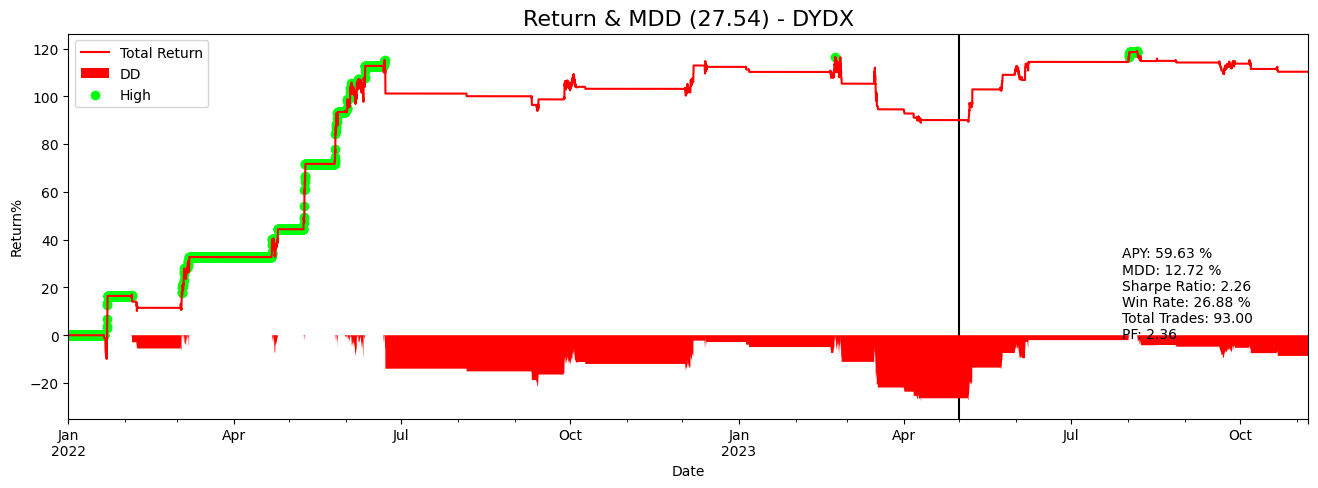

AVAX 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

OP 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

RUNE 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 48, 'multiplier': 2.5, 'mdd': 15.98, 'sharpe': 2.5018472152880418, 'calmar': 5.238298028672589, 'win rate': 37.22627737226277}
APY: 59.27 %
MDD: 9.32 %
MDD Duration 175 days 03:00:00
worst trade: -4.29 %
2022-03-31 13:00:00 ~ 2022-03-31 14:00:00
avg holding days: 0.20 days
--------------------------------------------
PF: 1.64
Sharpe Ratio: 2.50
Calmar Ratio: 5.24
Sortino Ratio: 4.17
Omega Ratio: 1.33
--------------------------------------------
Expectancy : 0.41 %
Total Time Exposure : 7.78 %
Total Trades: 274
Win Rate: 37.23 %
--------------------------------------------
PF * Win Rate: 0.610


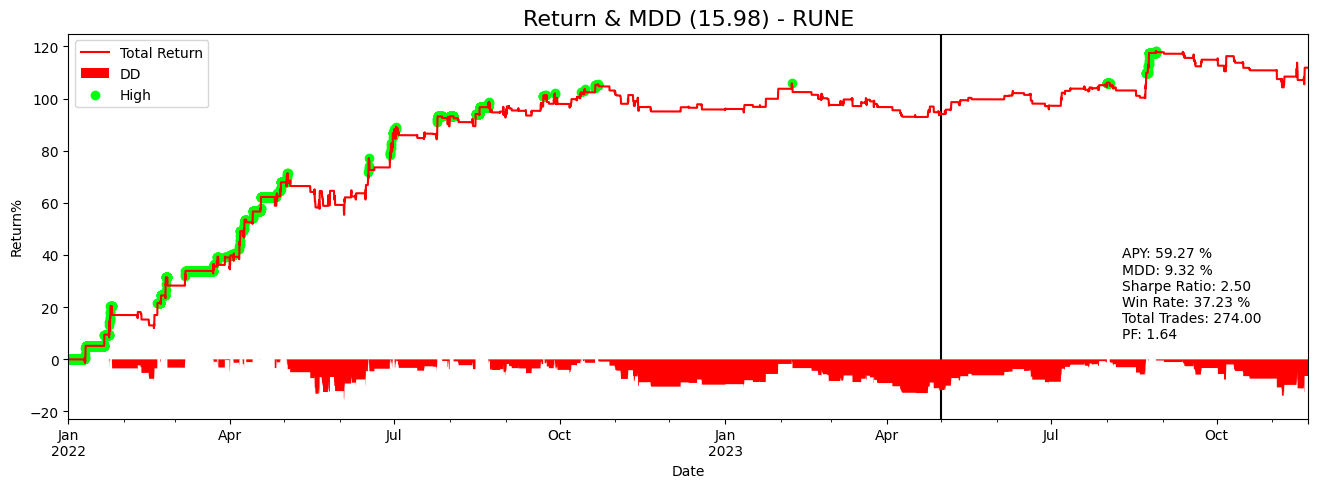

ARB 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 244, 'multiplier': 2.0, 'mdd': 6.57, 'sharpe': 2.2048794028284666, 'calmar': 7.892984466805843, 'win rate': 47.22222222222222}
APY: 41.42 %
MDD: 5.59 %
MDD Duration 100 days 15:00:00
worst trade: -1.37 %
2023-05-18 17:00:00 ~ 2023-05-18 19:00:00
avg holding days: 0.63 days
--------------------------------------------
PF: 3.12
Sharpe Ratio: 2.20
Calmar Ratio: 7.89
Sortino Ratio: 3.96
Omega Ratio: 1.28
--------------------------------------------
Expectancy : 0.76 %
Total Time Exposure : 9.42 %
Total Trades: 36
Win Rate: 47.22 %
--------------------------------------------
PF * Win Rate: 1.473


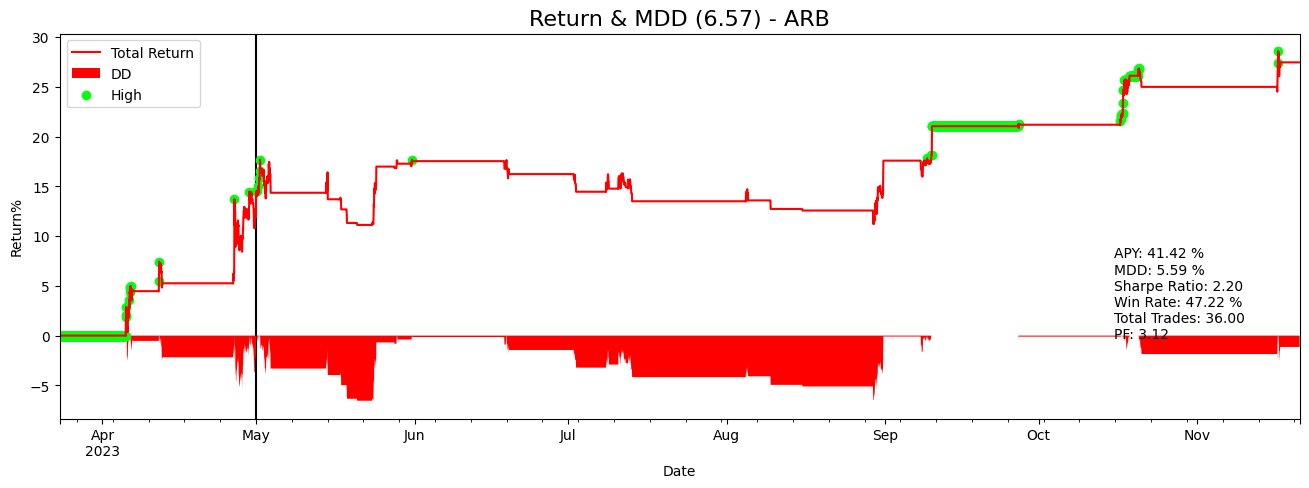

GMT 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

ETC 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

LDO 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GALA 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APE 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APT 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

EOS 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

NEAR 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

BLUR 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

WAVES 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

NEO 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GRT 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 1h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 136, 'multiplier': 2.5, 'mdd': 8.84, 'sharpe': 2.834241494393086, 'calmar': 12.508569660426687, 'win rate': 39.34426229508197}
APY: 76.27 %
MDD: 6.61 %
MDD Duration 55 days 09:00:00
worst trade: -5.47 %
2023-03-30 00:00:00 ~ 2023-03-30 02:00:00
avg holding days: 0.39 days
--------------------------------------------
PF: 2.58
Sharpe Ratio: 2.83
Calmar Ratio: 12.51
Sortino Ratio: 5.37
Omega Ratio: 1.44
--------------------------------------------
Expectancy : 0.93 %
Total Time Exposure : 8.82 %
Total Trades: 61
Win Rate: 39.34 %
--------------------------------------------
PF * Win Rate: 1.015


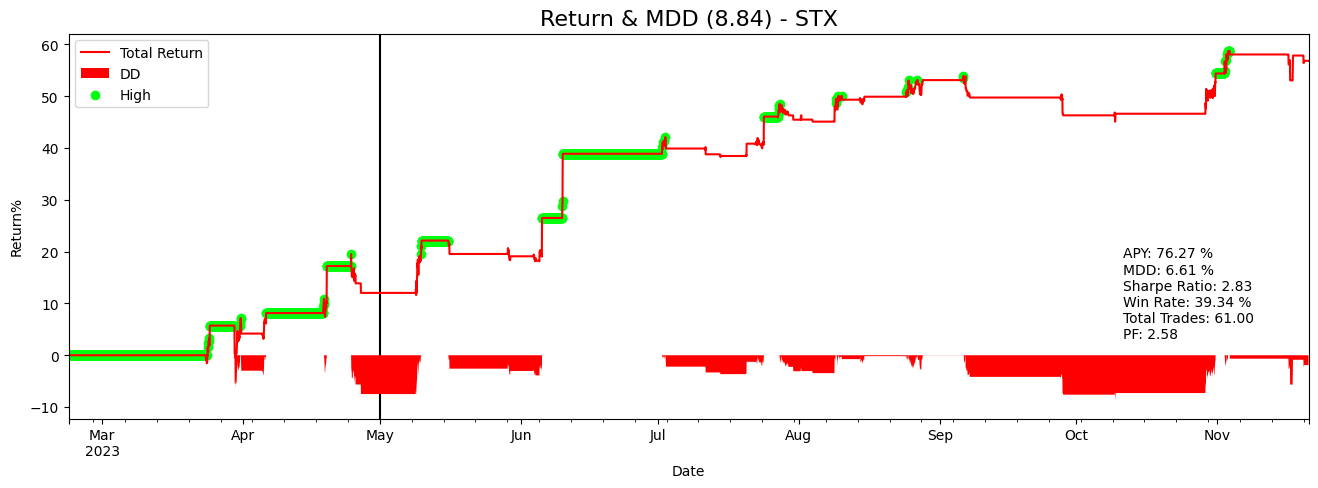

BTC 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

OP 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

ARB 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GMT 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

LDO 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

INJ 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

APT 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

SUSHI 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

FET 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

GRT 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

STX 4h


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

{'window_size': 152, 'multiplier': 2.0, 'mdd': 15.04, 'sharpe': 2.786409899159954, 'calmar': 8.099956587387926, 'win rate': 38.88888888888889}
APY: 88.86 %
MDD: 12.03 %
MDD Duration 66 days 16:00:00
worst trade: -3.43 %
2023-05-04 04:00:00 ~ 2023-05-08 08:00:00
avg holding days: 2.49 days
--------------------------------------------
PF: 4.49
Sharpe Ratio: 2.79
Calmar Ratio: 8.10
Sortino Ratio: 5.02
Omega Ratio: 1.65
--------------------------------------------
Expectancy : 3.68 %
Total Time Exposure : 16.44 %
Total Trades: 18
Win Rate: 38.89 %
--------------------------------------------
PF * Win Rate: 1.746


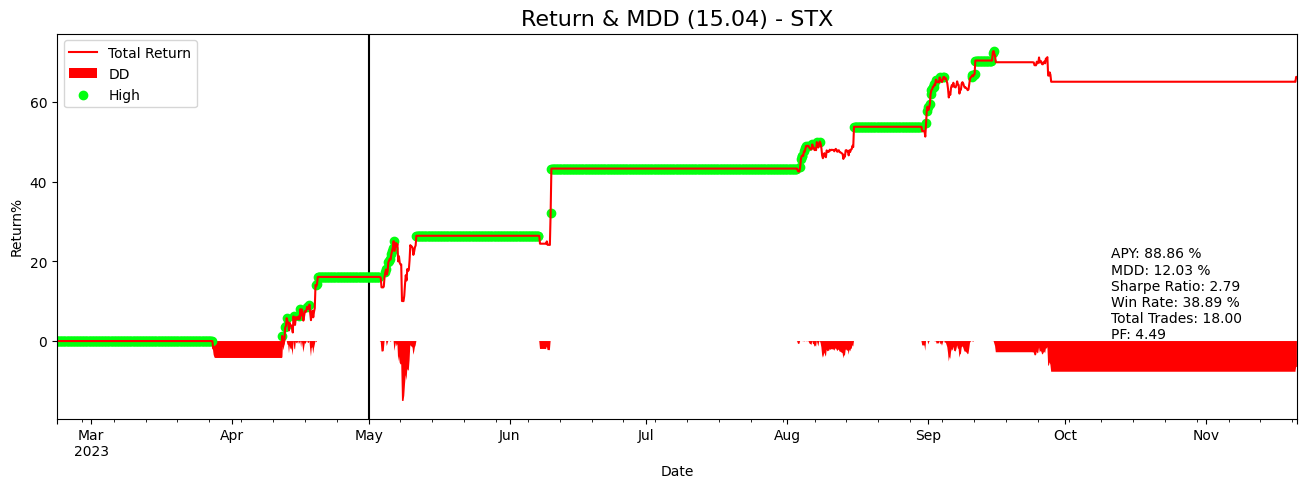

In [18]:
for freq in insample_short_dict.keys():
    for coin in insample_long_dict[freq]:
        print(coin, freq)
        in_out_test(freq,coin,'short')

In [ ]:
for freq in insample_long_dict.keys():
    for coin in insample_long_dict[freq]:
        print(coin, freq)
        in_out_test(freq,coin,'short')

In [12]:
import hiplot as hip
freq = '15T'
for direction in ['long','short']:
    print(f'-------------------------frequency:{freq}----------------------direction:{direction}---------------------')
    outample_params_highland('15T', direction, 'AVAX')


-------------------------frequency:15T----------------------direction:long---------------------


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

-------------------------frequency:15T----------------------direction:short---------------------


Processing:   0%|          | 0/97 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 挑選參數全樣本結果

APY: 128.45 %
MDD: 15.98 %
MDD Duration 95 days 01:00:00
worst trade: -10.75 %
2022-09-07 04:00:00 ~ 2022-09-09 03:00:00
avg holding days: 5.29 days
--------------------------------------------
PF: 2.64
Sharpe Ratio: 2.16
Calmar Ratio: 5.79
Sortino Ratio: 3.26
Omega Ratio: 1.10
--------------------------------------------
Expectancy : 2.47 %
Total Time Exposure : 75.38 %
Total Trades: 97
Win Rate: 52.58 %
--------------------------------------------
PF * Win Rate: 1.385


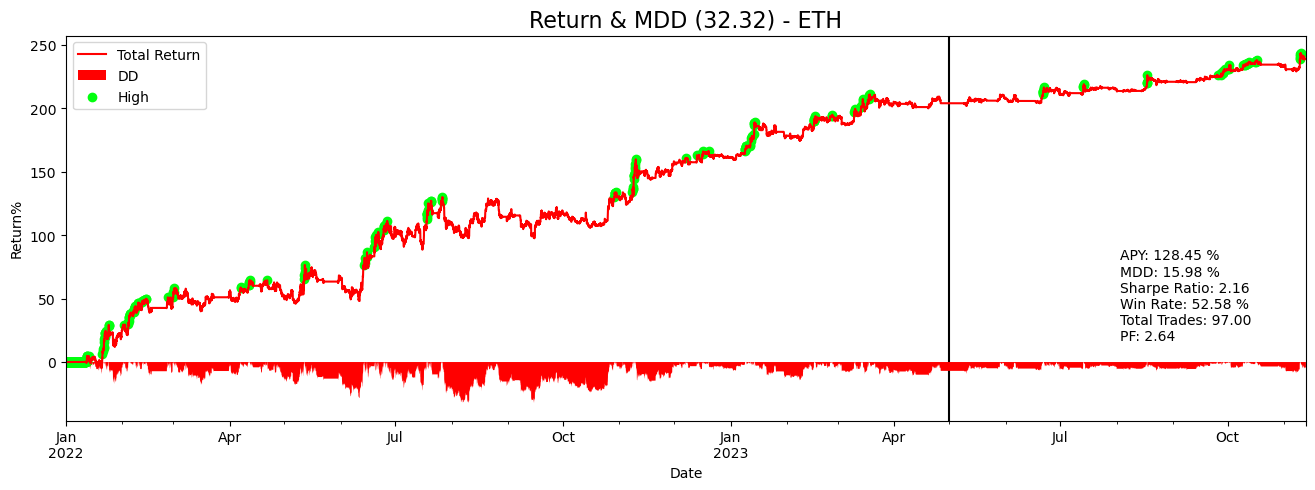

(None,
 Start                               2022-01-01 00:00:00
 End                                 2023-11-12 23:00:00
 Period                                681 days 00:00:00
 Start Value                                     10000.0
 Min Value                                   9524.910264
 Max Value                                  34363.056868
 End Value                                  33929.683914
 Total Return [%]                             239.296839
 Benchmark Return [%]                         -44.573538
 Total Time Exposure [%]                       75.379344
 Max Gross Exposure [%]                        108.13714
 Max Drawdown [%]                              15.981857
 Max Drawdown Duration                  95 days 01:00:00
 Total Orders                                        185
 Total Fees Paid                              582.121873
 Total Trades                                         97
 Win Rate [%]                                   52.57732
 Best Trade [%]         

In [3]:
start = '2022-01-01'
sep = ''
end = ''

side = 'both'

params = {'window_l_k': 48, 'window_l_d': 132, 'window_s_k': 52, 'window_s_d': 140}
# sol 1h : 40,48,100,126,95 original
config = {'freq':'1h', 'lag':1, 'fee': 0.0003}
coin = 'ETH'
df = df_dict[coin]
strategy = Strategy(df=df.loc[start:], configs=config)
_pf = strategy.strategy(side = side,params=params)
trades = _pf.trades.records_readable
analyze = Analyzer(strategy)
analyze.show_pf_analysis(params, side, coin, axv_index=['2023-05-01'])